# Low-noise versions of `dynamic-2.ipynb`

_23 August 2021_ <br />
_Chuan-Zheng Lee <czlee@stanford.edu>_ <br />
_Rough working_

This is an effort to investigate why the digital schemes in `dynamic-2.ipynb` don't converge as expected.

The results here are basically that we should set the quantization range quantiles to 1.0, not 0.9 as they were previously. Changing this hyperparameter recovers the unconstrained performance. It's most apparent when you look at the plots of the quantization range, and note that the maximum is about an order of magnitude greater than the 90th percentile. I expected this, which is why I set the quantile to 0.9—it was to avoid outliers unduly affecting precision. But it turns out that covering entire range seems to be more important.

In [1]:
import matplotlib.pyplot as plt
from plotting import plot_averaged_training_charts, plot_comparison, make_axes, show_timestamp_info

In [2]:
common_specs = {
    'rounds':                 ('expect', 150),
    'batch_size':             ('expect-if', 64),
    'epochs':                 ('expect', 1),
    'ema_coefficient':        ('expect', 1 / 3),
    'save_squared_error':     ('expect', False),
    'send':                   ('expect', 'deltas'),
    'optimizer_client':       ('expect', 'sgd'),
    'clients':                ('title',  20),
    'lr_scheduler_client':    ('expect', 'none'),
}
base_analog_specs = common_specs.copy()
base_analog_specs.update({
    'script': 'dynpower.py',
    'power':                  ('title',  1.0),
    'power_update_period':    ('expect', 1),
    'power_quantile':         ('expect', 0.9),
    'power_factor':           ('expect', 0.9),
    'noise':                  ('series', 1e-6),
})
base_digital_specs = common_specs.copy()
base_digital_specs.update({
    'script': 'dynquant.py',
    'power':                  ('title',  1.0),
    'qrange_update_period':   ('expect', 1),
    'qrange_param_quantile':  ('series', '__all__'),
    'qrange_client_quantile': ('series', '__all__'),
    'channel_uses':           ('expect', None),
    'rounding_method':        ('expect', 'stochastic'),
    'parameter_schedule':     ('expect', 'staggered'),
    'zero_bits_strategy':     ('expect', 'read-zero'),
    'noise':                  ('series', '__all__'),
})
base_dynrange_specs = common_specs.copy()
base_dynrange_specs.update({
    'script': 'dynrange.py',
    'qrange_update_period':   ('expect', 1),
    'qrange_param_quantile':  ('series', '__all__'),
    'qrange_client_quantile': ('series', '__all__'),
})

def add_specs_to_base(specs):
    """Updates each of the three base specs with `specs`, and returns a 3-tuple."""
    analog_specs = base_analog_specs.copy()
    digital_specs = base_digital_specs.copy()
    dynrange_specs = base_dynrange_specs.copy()
    analog_specs.update(specs)
    digital_specs.update(specs)
    dynrange_specs.update(specs)
    return analog_specs, digital_specs, dynrange_specs

unconstrained_kwargs = {'linestyle': 'dotted', 'label': 'unconstrained', 'linewidth': 3}

paths = [
    "results/20210823-epsilon-analog",
    "results/20210823-epsilon-digital",
    "results/20210823-fmnist-simple",
    "results/20210823-fmnist-cnn2",
    "results/20210823-cifar10-simple",
    "results/20210823-cifar10-resnet20",
    "results/20210823-lonoise-p1",
    "results/20210823-lonoise-p2",
    "results/20210823-lonoise-g2",
    "results/20210823-lonoise-g3",
    "results/20210823-lonoise-g4",
    "results/20210823-lonoise-g6",
]

# epsilon

| experiments | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **23 Aug 2021, 02:17:42** | 23 Aug 2021, 03:00:49 | 43 min 07 s |
| last to finish | 24 Aug 2021, 08:47:18 | **24 Aug 2021, 09:26:56** | 39 min 38 s |
| shortest | 23 Aug 2021, 12:23:18 | 23 Aug 2021, 12:28:17 | **4 min 59 s** |
| longest | 24 Aug 2021, 07:56:31 | 24 Aug 2021, 09:13:18 | **1 h 16 min 46 s** |


- Skipping 37 runs using 1 other scripts: dynrange.py (37)
- Skipping 198 runs that don't match on 3 keys: clients (180), dataset (145), noise (111)
- Skipping 37 runs using 1 other scripts: dynrange.py (37)
- Skipping 226 runs that don't match on 3 keys: clients (213), dataset (169), noise (76)
- Skipping 479 runs using 2 other scripts: dynquant.py (263), dynpower.py (216)
- Skipping 28 runs that don't match on 2 keys: clients (28), dataset (24)


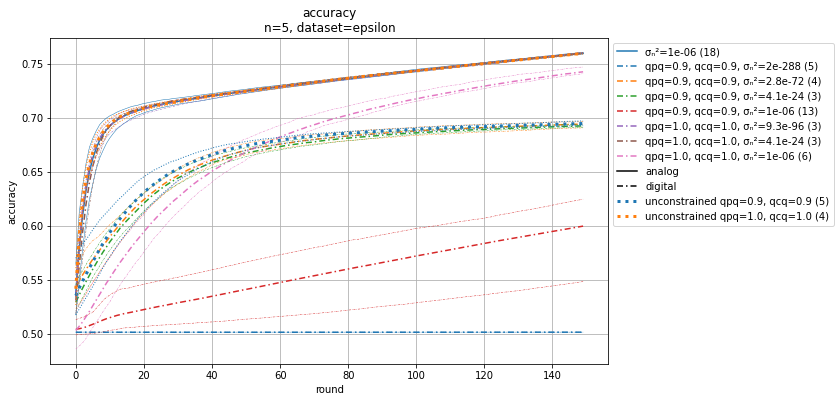

In [3]:
epsilon_specs = {
    'dataset':                ('title',  'epsilon'),
    'lr_client':              ('expect-if', 0.01),
    'momentum_client':        ('expect-if', 0.0),
    'weight_decay_client':    ('expect-if', 0.0),
    'data_per_client':        ('expect-if', 20000),
    'clients':                ('title',  5), 
}
analog_specs, digital_specs, dynrange_specs = add_specs_to_base(epsilon_specs)
digital_specs['noise'] = ('series', lambda x: x <= 1e-6)

show_timestamp_info(paths)
axs = make_axes(1, axsize=(10, 6))
plot_comparison('accuracy', paths, analog_specs, digital_specs, both_legends=True, ax=axs[0], extra_lines=['range'])
plot_averaged_training_charts(paths, ['accuracy'], dynrange_specs, axs=axs, **unconstrained_kwargs, extra_lines=['range'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

<div class="alert alert-success">Changing to <code>qpq=1 qcq=1</code> seems to get it to match analog $\sigma_\mathrm{n}^2 = 10^{-6}$ performance at 8 bits per parameter ($\sigma_\mathrm{n}^2 = 4.1 \times 10^{-24}$).</div>

- Skipping 37 runs using 1 other scripts: dynrange.py (37)
- Skipping 198 runs that don't match on 3 keys: dataset (145), noise (111), clients (36)
- Skipping 37 runs using 1 other scripts: dynrange.py (37)
- Skipping 230 runs that don't match on 3 keys: dataset (169), noise (76), clients (50)
- Skipping 479 runs using 2 other scripts: dynquant.py (263), dynpower.py (216)
- Skipping 33 runs that don't match on 2 keys: dataset (24), clients (9)


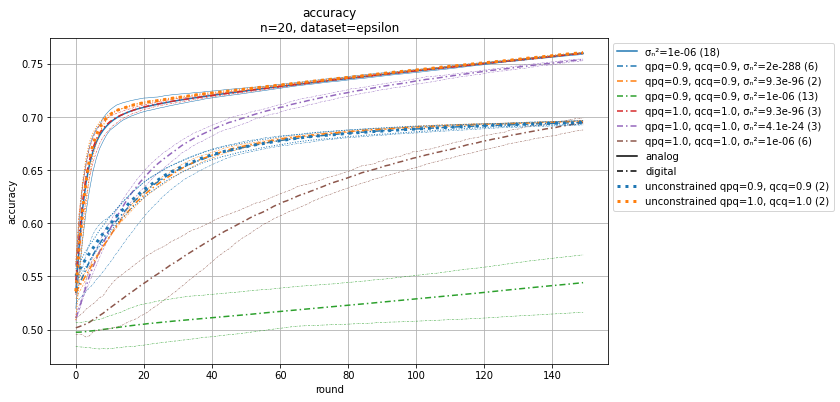

In [4]:
analog_specs['clients'] = ('title', 20)
digital_specs['clients'] = ('title', 20)
dynrange_specs['clients'] = ('title', 20)

axs = make_axes(1, axsize=(10, 6))
plot_comparison('accuracy', paths, analog_specs, digital_specs, both_legends=True, ax=axs[0], extra_lines=['range'])
plot_averaged_training_charts(paths, ['accuracy'], dynrange_specs, axs=axs, **unconstrained_kwargs, extra_lines=['range'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

<div class="alert alert-success">Changing to <code>qpq=1 qcq=1</code> seems to get it to match analog $\sigma_\mathrm{n}^2 = 10^{-6}$ performance at 8 bits per parameter ($\sigma_\mathrm{n}^2 = 9.3 \times 10^{-96}$).</div>

- Skipping 253 runs using 2 other scripts: dynpower.py (216), dynrange.py (37)
- Skipping 219 runs that don't match on 2 keys: dataset (169), clients (50)
- Skipping 479 runs using 2 other scripts: dynquant.py (263), dynpower.py (216)
- Skipping 33 runs that don't match on 2 keys: dataset (24), clients (9)


(0.0, 0.02)

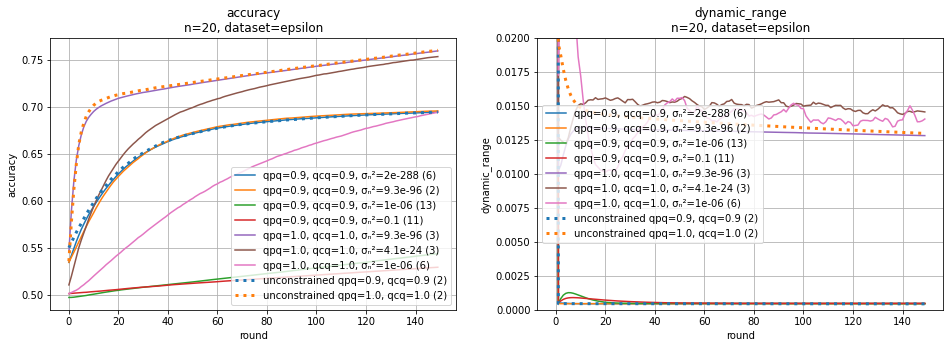

In [5]:
digital_specs['noise'] = ('series', '__all__')
axs = make_axes(2)
plot_averaged_training_charts(paths, ['accuracy', 'quantization_range'], digital_specs, axs=axs)
plot_averaged_training_charts(paths, ['accuracy', 'dynamic_range'], dynrange_specs, axs=axs, **unconstrained_kwargs)
plt.ylim((0, 0.02))

# Fashion-MNIST simple

| experiments | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **23 Aug 2021, 02:17:42** | 23 Aug 2021, 03:00:49 | 43 min 07 s |
| last to finish | 24 Aug 2021, 08:47:18 | **24 Aug 2021, 09:26:56** | 39 min 38 s |
| shortest | 23 Aug 2021, 12:23:18 | 23 Aug 2021, 12:28:17 | **4 min 59 s** |
| longest | 24 Aug 2021, 07:56:31 | 24 Aug 2021, 09:13:18 | **1 h 16 min 46 s** |


- Skipping 37 runs using 1 other scripts: dynrange.py (37)
- Skipping 195 runs that don't match on 4 keys: dataset (151), noise (111), lr_client (87), clients (36)
- Skipping 37 runs using 1 other scripts: dynrange.py (37)
- Skipping 226 runs that don't match on 4 keys: dataset (211), noise (76), lr_client (53), clients (50)
- Skipping 479 runs using 2 other scripts: dynquant.py (263), dynpower.py (216)
- Skipping 28 runs that don't match on 3 keys: dataset (28), clients (9), lr_client (7)


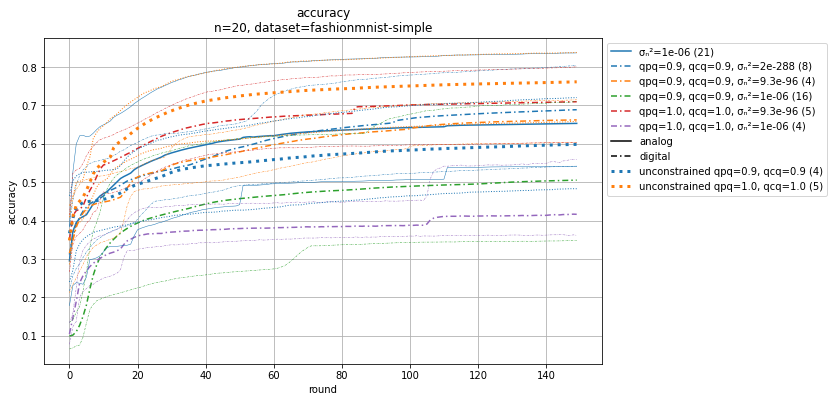

In [6]:
fmnist_simple_specs = {
    'dataset':                ('title',  'fashionmnist-simple'),
    'lr_client':              ('filter', 0.01),
    'momentum_client':        ('expect-if', 0.0),
    'weight_decay_client':    ('expect-if', 0.0),
    'data_per_client':        ('expect-if', None),
    'clients':                ('title',  20),
}

analog_specs, digital_specs, dynrange_specs = add_specs_to_base(fmnist_simple_specs)
digital_specs['noise'] = ('series', lambda x: x <= 1e-6)

show_timestamp_info(paths)
axs = make_axes(1, axsize=(10, 6))
plot_comparison('accuracy', paths, analog_specs, digital_specs, both_legends=True, ax=axs[0], extra_lines=['range'])
plot_averaged_training_charts(paths, ['accuracy'], dynrange_specs, axs=axs, **unconstrained_kwargs, extra_lines=['range'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

Trying some noise levels near $10^{-6}$, as well as the no-noise analog case, to see what happens. Note that in the following plot I tried a lower learning rate to see if it would reduce the noise. (It doesn't, and it just makes the training worse.)

- Skipping 300 runs using 2 other scripts: dynquant.py (263), dynrange.py (37)
- Skipping 172 runs that don't match on 3 keys: dataset (151), noise (95), clients (36)


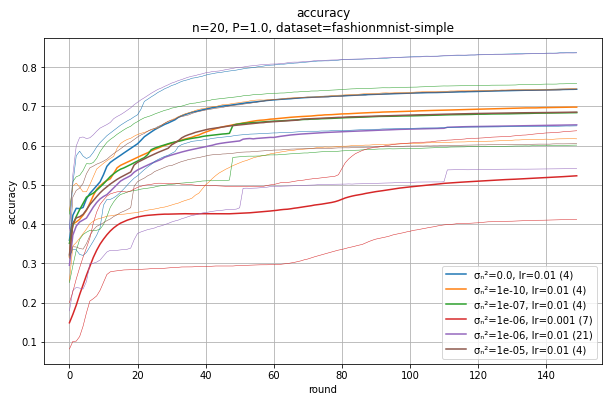

In [7]:
analog_specs['lr_client'] = ('series', '__all__')
analog_specs['noise'] = ('series', lambda x: x <= 1e-4)
axs = make_axes(1, axsize=(10, 6))
plot_averaged_training_charts(paths, ['accuracy'], analog_specs, axs=axs, extra_lines=['range'])

- Skipping 253 runs using 2 other scripts: dynpower.py (216), dynrange.py (37)
- Skipping 226 runs that don't match on 4 keys: dataset (211), noise (76), lr_client (53), clients (50)
- Skipping 479 runs using 2 other scripts: dynquant.py (263), dynpower.py (216)
- Skipping 28 runs that don't match on 3 keys: dataset (28), clients (9), lr_client (7)


(0.0, 0.02)

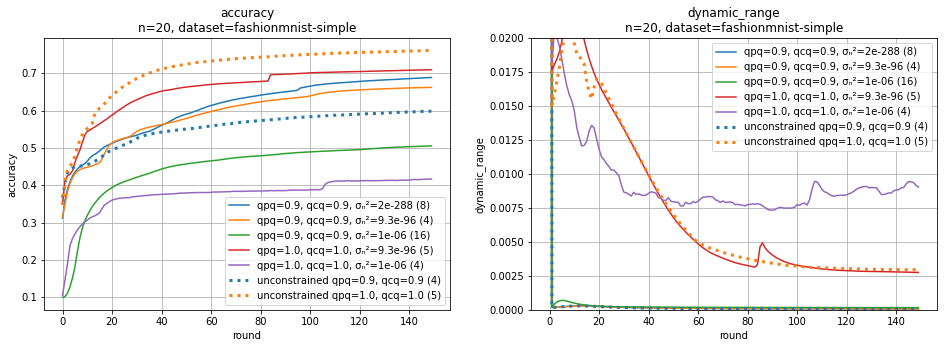

In [8]:
axs = make_axes(2)
plot_averaged_training_charts(paths, ['accuracy', 'quantization_range'], digital_specs, axs=axs)
plot_averaged_training_charts(paths, ['accuracy', 'dynamic_range'], dynrange_specs, axs=axs, **unconstrained_kwargs)
plt.ylim((0, 0.02))

# Fashion-MNIST CNN2

| experiments | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **23 Aug 2021, 02:17:42** | 23 Aug 2021, 03:00:49 | 43 min 07 s |
| last to finish | 24 Aug 2021, 08:47:18 | **24 Aug 2021, 09:26:56** | 39 min 38 s |
| shortest | 23 Aug 2021, 12:23:18 | 23 Aug 2021, 12:28:17 | **4 min 59 s** |
| longest | 24 Aug 2021, 07:56:31 | 24 Aug 2021, 09:13:18 | **1 h 16 min 46 s** |


- Skipping 37 runs using 1 other scripts: dynrange.py (37)
- Skipping 193 runs that don't match on 3 keys: dataset (171), noise (111), clients (36)
- Skipping 37 runs using 1 other scripts: dynrange.py (37)
- Skipping 222 runs that don't match on 4 keys: dataset (199), noise (76), clients (50), qrange_param_quantile (3)
- Skipping 479 runs using 2 other scripts: dynquant.py (263), dynpower.py (216)
- Skipping 29 runs that don't match on 2 keys: dataset (29), clients (9)


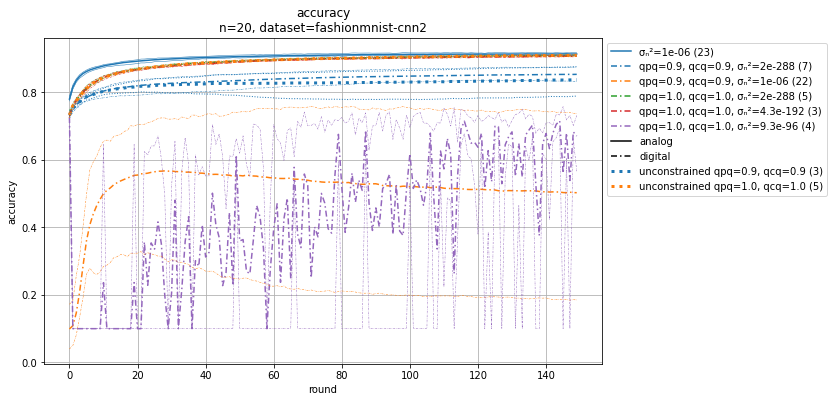

In [9]:
fmnist_cnn2_specs = {
    'dataset':                ('title',  'fashionmnist-cnn2'),
    'momentum_client':        ('expect-if', 0.0),
    'weight_decay_client':    ('expect-if', 0.0),
    'data_per_client':        ('expect-if', None),
    'clients':                ('title',  20),
}

analog_specs, digital_specs, dynrange_specs = add_specs_to_base(fmnist_cnn2_specs)
analog_specs['lr_client'] = ('expect-if', 0.05)
dynrange_specs['lr_client'] = ('expect-if', 0.01)
digital_specs.update({
    'lr_client':              ('expect-if', 0.01),
    'noise':                  ('series', lambda x: x <= 1e-6),
    'qrange_param_quantile':  ('series', [0.9, 1.0]),
    'qrange_client_quantile': ('series', [0.9, 1.0]),
})

show_timestamp_info(paths)
axs = make_axes(1, axsize=(10, 6))
plot_comparison('accuracy', paths, analog_specs, digital_specs, both_legends=True, ax=axs[0], extra_lines=['range'])
plot_averaged_training_charts(paths, ['accuracy'], dynrange_specs, axs=axs, **unconstrained_kwargs, extra_lines=['range'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

<div class="alert alert-success">Changing to <code>qpq=1 qcq=1</code> seems to get it to match analog $\sigma_\mathrm{n}^2 = 10^{-6}$ performance at 24 bits per parameter ($\sigma_\mathrm{n}^2 = 2 \times 10^{-288}$), but not 8 bits per parameter ($\sigma_\mathrm{n}^2 = 9.3 \times 10^{-96}$).</div>

Though, why is the 8-bit case so chaotic?

- Skipping 253 runs using 2 other scripts: dynpower.py (216), dynrange.py (37)
- Skipping 222 runs that don't match on 4 keys: dataset (199), noise (76), clients (50), qrange_param_quantile (3)
- Skipping 479 runs using 2 other scripts: dynquant.py (263), dynpower.py (216)
- Skipping 29 runs that don't match on 2 keys: dataset (29), clients (9)
- Skipping 253 runs using 2 other scripts: dynpower.py (216), dynrange.py (37)
- Skipping 222 runs that don't match on 4 keys: dataset (199), noise (76), clients (50), qrange_param_quantile (3)
- Skipping 479 runs using 2 other scripts: dynquant.py (263), dynpower.py (216)
- Skipping 29 runs that don't match on 2 keys: dataset (29), clients (9)


(0.0, 0.003)

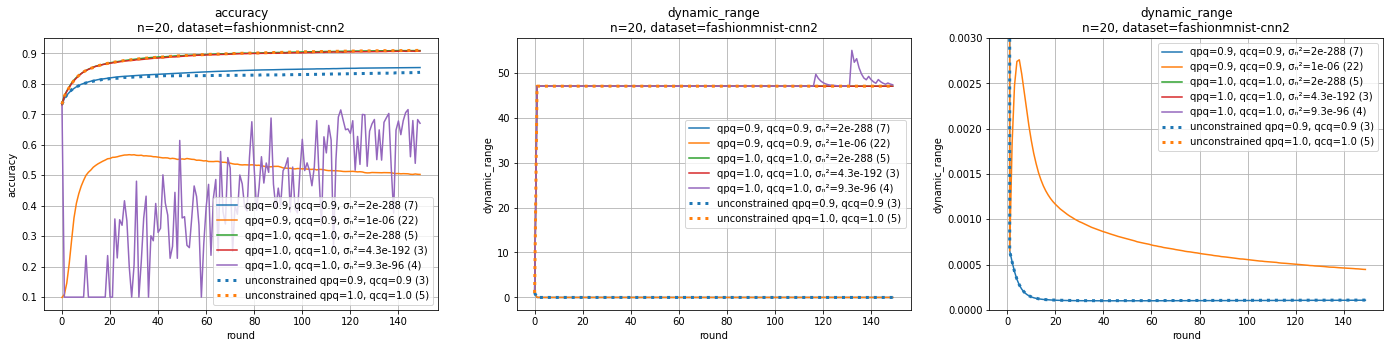

In [10]:
digital_specs['noise'] = ('series', lambda x: x <= 1e-6)
axs = make_axes(3)
plot_averaged_training_charts(paths, ['accuracy', 'quantization_range'], digital_specs, axs=axs[:2])
plot_averaged_training_charts(paths, ['accuracy', 'dynamic_range'], dynrange_specs, axs=axs[:2], **unconstrained_kwargs)

# zoom in a bit on the second plot
plot_averaged_training_charts(paths, ['quantization_range'], digital_specs, axs=axs[2:3])
plot_averaged_training_charts(paths, ['dynamic_range'], dynrange_specs, axs=axs[2:3], **unconstrained_kwargs)
axs[2].set_ylim((0, 0.003))

I also tried the case where $\sigma_\mathrm{n} = 10^{-6}$, and even at a learning rate as low as $10^{-10}$, it diverges very quickly. Note how larger the maximum is than the 90th percentile in the above plot! I'm picking the one-bit-per-parameter thing is prohibitive here, and we should be sticking with the 90th percentile.

The dynamic range is around 47 for all cases where `qpq=1, qcq=1`, but less than 0.001 for the other cases. That's about 50,000 times larger—you'd need 16 bits to even register 0.001 when your range is 47. So 8 bits per parameter (when noise is 9.3e-96) isn't going to cut it.

Maybe different `qpq=0.5` or `qpq=0.99`?

- Skipping 253 runs using 2 other scripts: dynpower.py (216), dynrange.py (37)
- Skipping 219 runs that don't match on 3 keys: dataset (199), noise (76), clients (50)


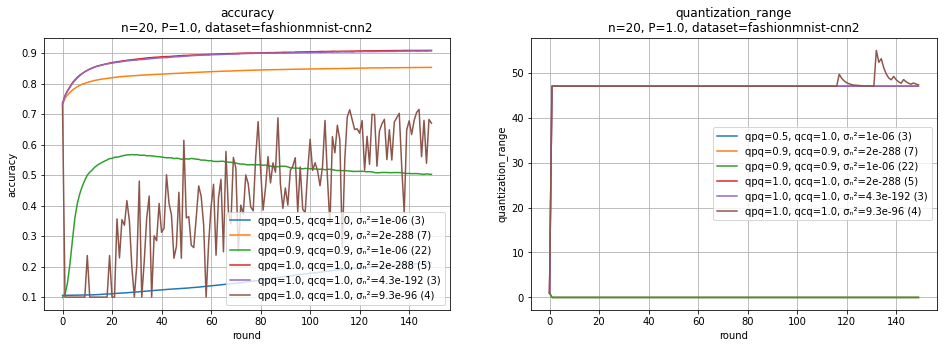

In [11]:
digital_specs.update({
    'lr_client':              ('expect-if', 0.01),
    'noise':                  ('series', lambda x: x <= 1e-6),
    'qrange_param_quantile':  ('series', '__all__'),
    'qrange_client_quantile': ('series', '__all__'),
})

axs = make_axes(2)
plot_averaged_training_charts(paths, ['accuracy', 'quantization_range'], digital_specs, axs=axs)

# CIFAR-10 simple

| experiments | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **23 Aug 2021, 02:17:42** | 23 Aug 2021, 03:00:49 | 43 min 07 s |
| last to finish | 24 Aug 2021, 08:47:18 | **24 Aug 2021, 09:26:56** | 39 min 38 s |
| shortest | 23 Aug 2021, 12:23:18 | 23 Aug 2021, 12:28:17 | **4 min 59 s** |
| longest | 24 Aug 2021, 07:56:31 | 24 Aug 2021, 09:13:18 | **1 h 16 min 46 s** |


- Skipping 37 runs using 1 other scripts: dynrange.py (37)
- Skipping 208 runs that don't match on 3 keys: dataset (201), noise (111), clients (36)
- Skipping 37 runs using 1 other scripts: dynrange.py (37)
- Skipping 245 runs that don't match on 3 keys: dataset (238), noise (76), clients (50)
- Skipping 479 runs using 2 other scripts: dynquant.py (263), dynpower.py (216)
- Skipping 32 runs that don't match on 2 keys: dataset (32), clients (9)


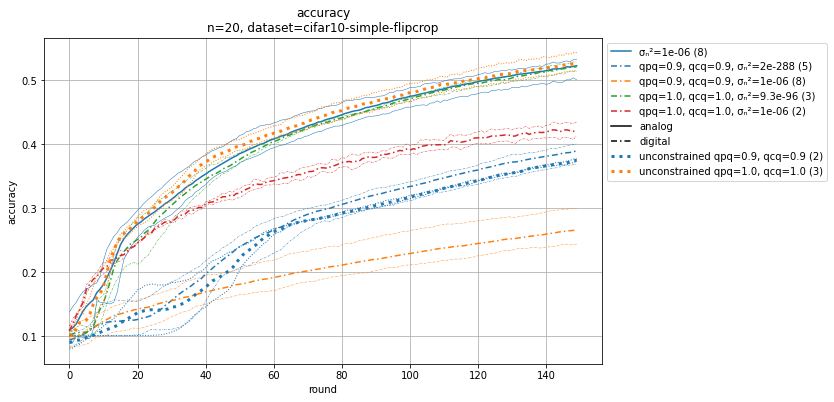

In [12]:
cifar10_simple_specs = {
    'dataset':                ('title',  'cifar10-simple-flipcrop'),
    'lr_client':              ('expect-if', 0.001),
    'momentum_client':        ('expect-if', 0.9),
    'weight_decay_client':    ('expect-if', 0.0),
    'data_per_client':        ('expect-if', None),
    'clients':                ('title',  20),
}

analog_specs, digital_specs, dynrange_specs = add_specs_to_base(cifar10_simple_specs)
digital_specs['noise'] = ('series', lambda x: x <= 1e-6)

show_timestamp_info(paths)
axs = make_axes(1, axsize=(10, 6))
plot_comparison('accuracy', paths, analog_specs, digital_specs, both_legends=True, ax=axs[0], extra_lines=['range'])
plot_averaged_training_charts(paths, ['accuracy'], dynrange_specs, axs=axs, **unconstrained_kwargs, extra_lines=['range'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

<div class="alert alert-success">Changing to <code>qpq=1 qcq=1</code> seems to get it to match analog $\sigma_\mathrm{n}^2 = 10^{-6}$ performance at 8 bits ($\sigma_\mathrm{n}^2 = 9.3 \times 10^{-96}$).</div>

- Skipping 253 runs using 2 other scripts: dynpower.py (216), dynrange.py (37)
- Skipping 238 runs that don't match on 2 keys: dataset (238), clients (50)
- Skipping 479 runs using 2 other scripts: dynquant.py (263), dynpower.py (216)
- Skipping 32 runs that don't match on 2 keys: dataset (32), clients (9)


(0.0, 0.02)

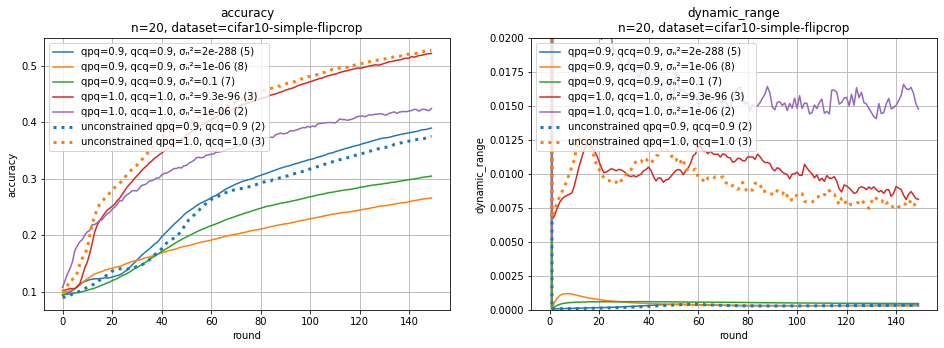

In [13]:
digital_specs['noise'] = ('series', '__all__')
axs = make_axes(2)
plot_averaged_training_charts(paths, ['accuracy', 'quantization_range'], digital_specs, axs=axs)
plot_averaged_training_charts(paths, ['accuracy', 'dynamic_range'], dynrange_specs, axs=axs, **unconstrained_kwargs)
plt.ylim((0, 0.02))

# CIFAR-10 ResNet

| experiments | started at | finished at | duration |
|--:|:-:|:-:|--:|
| first to start | **23 Aug 2021, 02:17:42** | 23 Aug 2021, 03:00:49 | 43 min 07 s |
| last to finish | 24 Aug 2021, 08:47:18 | **24 Aug 2021, 09:26:56** | 39 min 38 s |
| shortest | 23 Aug 2021, 12:23:18 | 23 Aug 2021, 12:28:17 | **4 min 59 s** |
| longest | 24 Aug 2021, 07:56:31 | 24 Aug 2021, 09:13:18 | **1 h 16 min 46 s** |


- Skipping 37 runs using 1 other scripts: dynrange.py (37)
- Skipping 206 runs that don't match on 3 keys: dataset (196), noise (111), clients (36)
- Skipping 37 runs using 1 other scripts: dynrange.py (37)
- Skipping 245 runs that don't match on 3 keys: dataset (235), noise (92), clients (50)
- Skipping 479 runs using 2 other scripts: dynquant.py (263), dynpower.py (216)
- Skipping 35 runs that don't match on 2 keys: dataset (35), clients (9)


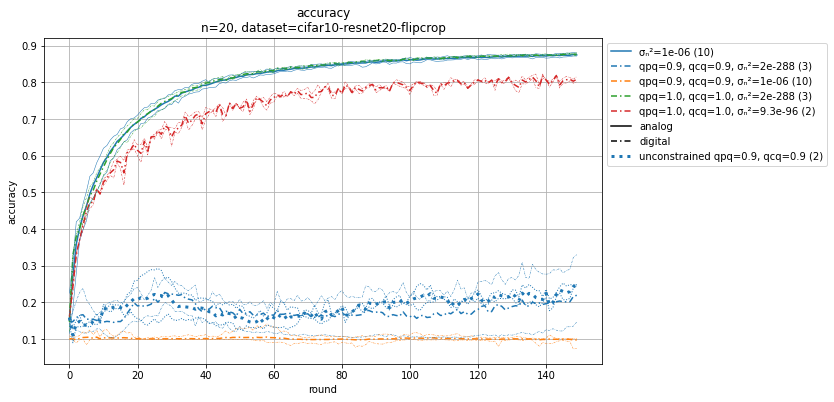

In [14]:
cifar10_resnet20_specs = {
    'dataset':                ('title',  'cifar10-resnet20-flipcrop'),
    'lr_client':              ('expect-if', 0.1),
    'momentum_client':        ('expect-if', 0.9),
    'weight_decay_client':    ('expect-if', 1e-4),
    'data_per_client':        ('expect-if', None),
    'clients':                ('title',  20),
    'batch_size':             ('expect-if', 128),
}

analog_specs, digital_specs, dynrange_specs = add_specs_to_base(cifar10_resnet20_specs)
digital_specs['noise'] = ('series', [1e-6, 9.3e-96, 2e-288])

show_timestamp_info(paths)
axs = make_axes(1, axsize=(10, 6))
plot_comparison('accuracy', paths, analog_specs, digital_specs, both_legends=True, ax=axs[0], extra_lines=['range'])
plot_averaged_training_charts(paths, ['accuracy'], dynrange_specs, axs=axs, **unconstrained_kwargs, extra_lines=['range'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

- Skipping 253 runs using 2 other scripts: dynpower.py (216), dynrange.py (37)
- Skipping 245 runs that don't match on 3 keys: dataset (235), noise (92), clients (50)
- Skipping 479 runs using 2 other scripts: dynquant.py (263), dynpower.py (216)
- Skipping 35 runs that don't match on 2 keys: dataset (35), clients (9)


(0.0, 0.015)

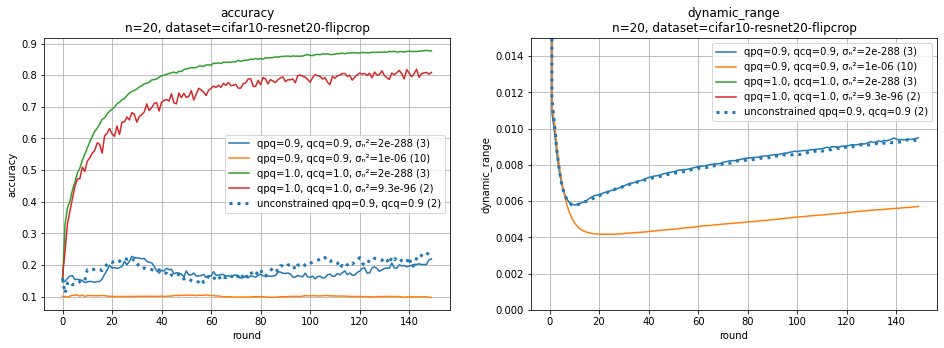

In [15]:
axs = make_axes(2)
plot_averaged_training_charts(paths, ['accuracy', 'quantization_range'], digital_specs, axs=axs)
plot_averaged_training_charts(paths, ['accuracy', 'dynamic_range'], dynrange_specs, axs=axs, **unconstrained_kwargs)
plt.ylim((0, 0.015))